# Amazon Direction Multi-Class Classification Model
-----------------

# Model Overview

**Goal:** Predict Amazon’s stock price direction within a 60-minute window, classifying movements into three categories:
- **0:** No significant change - Stock price only moves up or down in the performance window by less than 0.5%.
- **1:** Increasing in the Performance Window - Stock price moves up by at least 0.5% in the performance window.
- **2:** Decreasing in the Performance Window - Stock price moves down by at least 0.5% in the performance window.

## Target Creation
- **Target Variable:** The target variable, named ‘Direction,’ was created by calculating the percentage change in the stock price over the next 60 minutes. This calculation determines if the movement in price is significant enough to classify it as increasing (1), decreasing (2), or showing no significant change (0).

## Data Processing and Feature Engineering
- **Memory Optimization:** To handle the large dataset efficiently, numeric types were downcast where possible, reducing memory usage. This allowed for faster data processing and enabled the handling of extensive time series data without running into memory bottlenecks.
- **Project 1:** Initial feature set included basic features like the closing price and various technical indicators such as Accumulation/Distribution Line (AD), On-Balance Volume (OBV), and a custom TOS_STDEVALL_LR indicator. Additionally, stock-specific indicators for related companies like Microsoft (MSFT), Google (GOOGL), and Meta (META) were included to capture broader market sentiment.
  - **Result:** Despite a diverse set of features, the model struggled to differentiate between the stock movements, leading to poor predictive performance. The initial model faced difficulties in distinguishing between the three classes, with a particular weakness in predicting increases (class 1) and decreases (class 2).
- **Project 2:** In an attempt to enhance the model’s performance, more advanced features were engineered, including technical indicators like the Relative Strength Index (RSI), Simple Moving Average over 15 periods (SMA-15), and Simple Moving Average over 60 periods (SMA-60). These indicators provided additional context about market momentum and trends, which improved the accuracy of the model.

## Model Training and Validation
- **Class Weights:** Initially, class weights were balanced to address the inherent class imbalance in the dataset. However, after observing the model’s tendency to predict the majority class (class 0), the weights were adjusted to give more emphasis to the minority classes (1 and 2), amplifying their importance in the learning process.
- **Lookback Period:** Various lookback periods were tested to assess their impact on model accuracy. The lookback period defines how much historical data is considered when making predictions. By experimenting with different periods, the model’s ability to capture longer-term trends and short-term fluctuations was evaluated.
- **Feature Selection:** To avoid overfitting and reduce the complexity of the model, a k-best method was employed for feature selection. In each iteration, the top 10 features that contributed the most to the target variable were selected, ensuring that the model focused on the most relevant information.
- **Training Process:** An incremental learning approach with rolling windows was used to train the model. This method allows the model to learn from new data sequentially, making it more adaptable to changes in the market. The rolling windows approach also ensured that the model was trained on the most recent data, maintaining its relevance over time.
- **Training, Validation, and Testing:** Separate data splits were used to monitor performance throughout the modeling process. The training set was used for learning, the validation set for tuning hyperparameters and feature selection, and the testing set for evaluating the model’s final performance. This approach ensured that there was no overlap between data points, leading to more reliable and generalizable results.

## Rationale for Using For Loops
- **Performance:** For loops were utilized during the training process to keep the time required within a manageable range of 15-30 minutes per model. In contrast, vectorized operations, while typically faster, extended the training time beyond 30 minutes due to the complexity and size of the dataset.
- **Efficiency in Rolling Windows:** The use of for loops provided better control over the rolling windows approach, allowing the model to process data in a more structured manner. This approach reduced overhead and allowed for more efficient handling of sequential data, which is critical in time series analysis.
- **Memory Management:** For loops enabled processing in smaller chunks, reducing the memory load compared to vectorized operations, which are more memory-intensive. This strategy was particularly important given the large dataset and the need to minimize memory usage to avoid potential crashes or slowdowns.

## Stochastic Gradient Descent Classifier

### First Training Attempt (Lookback: 4320 Minutes ~ 3 Trading Days)
- **Class Weights:** 0: 0.46, 1: 2.35, 2: 2.49.
- **Validation Performance:**
  - **Accuracy:** 0.7207
  - **Precision:** 0.5195
  - **Recall:** 0.7207
  - **F1 Score:** 0.6038
- **Test Performance:**
  - **Accuracy:** 0.6581
  - **Precision:** 0.4331
  - **Recall:** 0.6581
  - **F1 Score:** 0.5224

### Inferences
- **Class Imbalance:** The model demonstrated a significant bias toward predicting the majority class (class 0). This was evident in the poor performance metrics for classes 1 and 2, where the model failed to make accurate predictions, indicating a severe class imbalance issue.
- **Model Bias:** The heavy bias toward class 0 suggests that the model was not learning the distinguishing features of the minority classes effectively. This could be due to the insufficient emphasis on these classes during training or the model’s inability to capture the nuances of stock price movements.
- **Need for Adjustment:** The poor initial performance highlighted the need for adjustments in the training process, particularly in class weighting and the selection of lookback periods. Without these adjustments, the model would continue to underperform in predicting increases and decreases in stock price.

### Adjustments Post First Attempt
- **Increased Lookback:** The lookback period was extended to provide the model with more historical data, offering additional context that could help improve its ability to classify stock movements accurately.
- **Increased Class Weights:** The class weights for the minority classes were further increased to amplify their importance during training. This adjustment aimed to address the class imbalance more effectively and encourage the model to learn from the underrepresented classes.

### Second Training Attempt (Lookback: 11700 Minutes ~ 30 Trading Days)
- **Class Weights:** 0: 0.46, 1 & 2: 10.0.
- **Validation Performance:**
  - **Accuracy:** 0.5269
  - **Precision:** 0.5854
  - **Recall:** 0.5269
  - **F1 Score:** 0.5329
- **Test Performance:**
  - **Accuracy:** 0.5374
  - **Precision:** 0.5485
  - **Recall:** 0.5374
  - **F1 Score:** 0.4989

### Inferences
- **Improved Performance:** The adjustments led to some improvement, particularly in precision, which reflects the model’s enhanced ability to correctly identify positive predictions (classes 1 and 2). However, the gains were modest, and the model still struggled with accurately predicting class 1 (increases).
- **Persistent Issues:** Despite the improvements, the model continued to face challenges in correctly classifying stock price increases. This suggests that while the adjustments helped, they were not sufficient to fully overcome the model’s limitations.
- **Model Limitation:** The limited performance gains indicated that the Stochastic Gradient Descent (SGD) classifier might not be the optimal choice for this task. Its linear nature and sensitivity to class imbalance were likely contributing factors to its underperformance.

## Decision Tree Classifier Results (Lookback: 7800 Minutes ~ 20 Trading Days)
- **Class Weights:** 0: 0.46, 1: 2.35, 2: 2.49.
- **Validation Performance:**
  - **Accuracy:** 0.421
  - **Precision:** 0.549
  - **Recall:** 0.421
  - **F1 Score:** 0.460
- **Test Performance:**
  - **Accuracy:** 0.486
  - **Precision:** 0.572
  - **Recall:** 0.486
  - **F1 Score:** 0.484

### Inferences
- **Balanced Predictions:** The Decision Tree model provided a better balance between precision and recall, particularly for class 2 (decreases). This indicates that the model was able to capture some of the nuances of stock price movements, making it more reliable in predicting decreases compared to the SGD classifier.
- **Class Imbalance:** While the model still struggled with class imbalance, it performed better than the SGD classifier in predicting the minority classes. This suggests that the tree-based approach was more effective at handling the imbalanced dataset, likely due to its ability to model non-linear relationships.
- **Practical Value:** The Decision Tree model’s ability to correctly predict half of the true decreases in the validation set makes it a valuable tool for risk-averse investors. Although it produced many false positives for decreases, its conservative approach can be beneficial for those who prefer to receive alerts even when they are not always accurate.

## KMeans Clustering Model Results (Lookback: 11700 Minutes ~ 30 Trading Days)

### Performance Results
- **Validation Set:**
  - **Accuracy:** 0.7207
  - **Precision:** 0.5195
  - **Recall:** 0.7207
  - **F1 Score:** 0.6038
- **Test Set:**
  - **Accuracy:** 0.6581
  - **Precision:** 0.4331
  - **Recall:** 0.6581
  - **F1 Score:** 0.5224

### Inferences
- **Class Imbalance:** The model is heavily biased toward predicting the majority class (class 0, "No significant change"). This is reflected in its inability to correctly predict classes 1 (increase) and 2 (decrease).
- **Clustering Limitations:** KMeans clustering is inherently unsuited for handling imbalanced datasets in classification tasks. The centroids were likely dominated by the majority class, leading the model to neglect the minority classes, even with custom class weights.
- **Impact of Class Weights:** Despite the use of custom class weights, the KMeans algorithm does not support class weighting effectively, which contributed to the poor performance for minority classes.
- **Model Unsuitability:** The results indicate that the KMeans model is not appropriate for predicting stock price direction, especially when the data is imbalanced. This underscores the challenges of using clustering algorithms in scenarios requiring precise classification of minority classes.

## Final Conclusions
The Decision Tree model emerged as the best-performing model, correctly predicting 50% of the true decreases in the stock market for the validation set and approximately 40% for the testing set. Although the model has many false positives for decreases, it can be valuable for risk-averse investors who prefer to receive conservative alerts, even if they aren’t always accurate. This conservative approach can be particularly useful for those with large unclaimed capital gains.

In contrast, the other models lacked real-world validity when it came to signaling investors effectively. Specifically:
- **Stochastic Gradient Descent Classifier:** While it showed some potential, it was significantly hampered by class imbalance and a bias toward the majority class (class 0), leading to poor performance in predicting increases (class 1) and decreases (class 2).
- **KMeans Clustering:** This model was found unsuitable for this classification task due to its inability to handle imbalanced datasets effectively. The clustering approach failed to provide meaningful predictions, particularly for minority classes.

In conclusion, the Decision Tree model, despite its imperfections, provided the most practical value for predicting stock price direction within a 60-minute window. For investors who prioritize minimizing risk, this model offers a useful tool, particularly for detecting potential decreases in stock price, even if it comes at the cost of generating some false alerts.


#### Package Import

In [11]:
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import FeatureAgglomeration
from sklearn.decomposition import PCA
from sklearn.exceptions import NotFittedError
from sklearn.model_selection import RandomizedSearchCV
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import label_binarize
from scipy.stats import mode
import warnings

In [12]:



def dataframe_to_html(df):
    """
    Convert a DataFrame to an HTML table.

    Parameters:
    df (pd.DataFrame): The DataFrame to convert.

    Returns:
    str: The HTML representation of the DataFrame.
    """
    # Convert the DataFrame to an HTML table
    html = df.to_html()
    
    # Return the HTML string
    return html



def htmldf(df):
    """
    Display a DataFrame as an HTML table in a Jupyter notebook.

    Parameters:
    
    df (pd.DataFrame): The DataFrame to display.
    """
    # Convert the DataFrame to an HTML table
    html = dataframe_to_html(df)
    
    # Display the HTML table
    display(HTML(html))

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

filtered_df = pd.read_csv('amzn_preprocessed_final.csv')
htmldf(filtered_df.head(5))

,timestamp,close,AD,OBV,TOS_STDEVALL_LR,MSFT,GOOGL,META,WMT,BABA,peak,epeak,valley,evalley,g_peak,m_peak,w_peak,b_peak,ms_peak,g_valley,m_valley,w_valley,b_valley,ms_valley,720w_ratio,A_M_ratio,A_B_ratio,A_G_ratio,A-B,A-MS,close_diff_1,close_diff_2,close_diff_3,close_diff_4,close_diff_5,Close_Discretized,Direction
0,2023-08-07 18:38:00+00:00,141.98,55506.779414,99508.0,126.08766,329.860,131.090,314.61,160.74,96.1928,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1.007395,0.451289,1.475994,1.083073,45.7872,-187.880,-0.04,-0.13,-0.12,-0.16,-0.19,1.0,0
1,2023-08-07 18:39:00+00:00,141.98,55341.989940,99508.0,126.08766,329.715,131.075,314.39,160.74,96.1928,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1.007395,0.451605,1.475994,1.083197,45.7872,-187.735,0.00,-0.04,-0.13,-0.12,-0.16,1.0,0
2,2023-08-07 18:40:00+00:00,141.99,57382.989940,101549.0,126.08766,329.735,131.085,314.34,160.70,96.1928,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1.007145,0.451708,1.476098,1.083190,45.7972,-187.745,0.01,0.01,-0.03,-0.12,-0.11,1.0,0
3,2023-08-07 18:41:00+00:00,142.01,58064.418511,103139.0,126.08766,329.720,131.120,314.34,160.69,96.1928,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1.007082,0.451772,1.476306,1.083054,45.8172,-187.710,0.02,0.03,0.03,-0.01,-0.10,1.0,0
4,2023-08-07 18:42:00+00:00,142.04,58222.418511,104245.0,126.08766,329.630,131.055,314.34,160.66,96.1928,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1.006894,0.451867,1.476618,1.083820,45.8472,-187.590,0.03,0.05,0.06,0.06,0.02,1.0,0


* The plot below shows the class proportions for each of the directional classifiers within the data-set

In [14]:
filtered_df = filtered_df.drop(columns = 'Direction')

* Above we can see there class weights for the up and down classes is about even while the neutral class makes up the majority of the data, this is expected when dealing with stock pricing.
------------------------

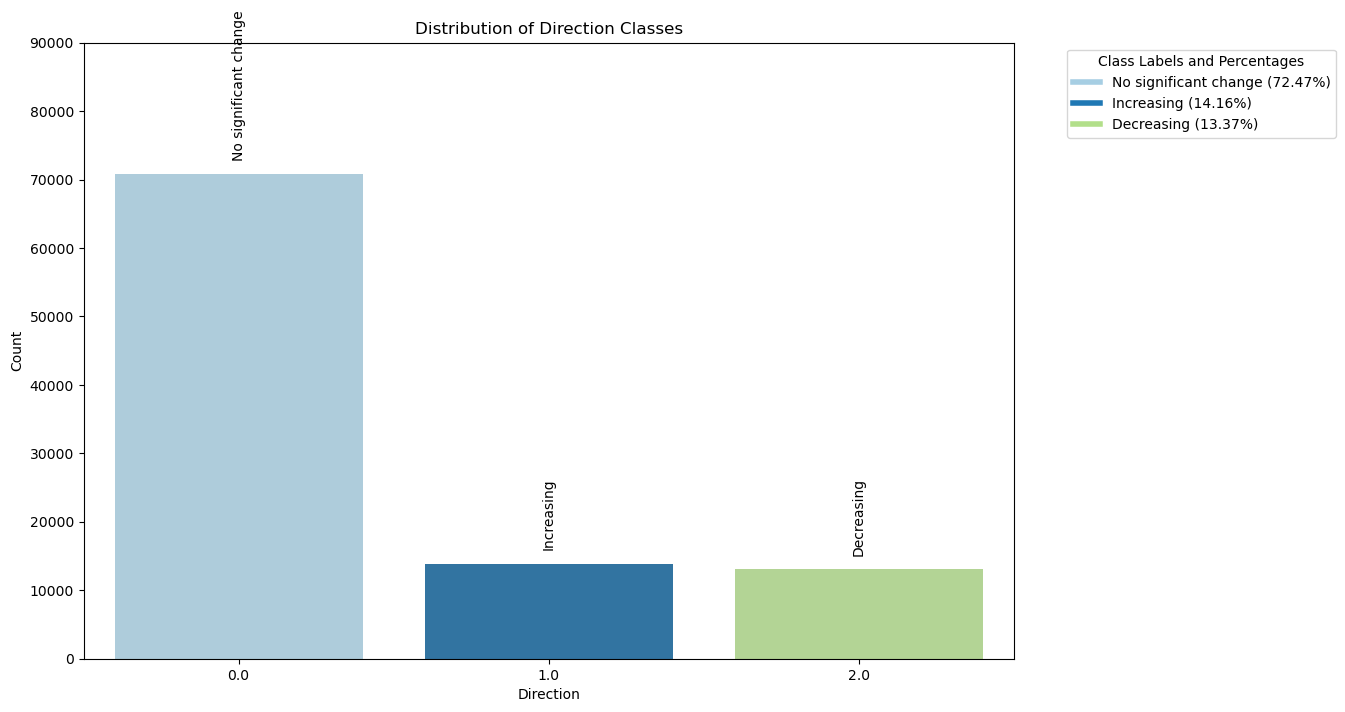

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def create_target_classes(df, column='close', period=60):
    df['Future_Close'] = df[column].shift(-period)  # Look forward 60 minutes
    df['Pct_Change'] = (df['Future_Close'] / df[column]) - 1
    conditions = [
        (df['Pct_Change'] <= -0.005),
        (df['Pct_Change'] > -0.005) & (df['Pct_Change'] <= 0.005),
        (df['Pct_Change'] > 0.005)
    ]
    choices = [2, 0, 1]
    df['Direction'] = np.select(conditions, choices, default=np.nan)
    df = df.drop(columns=['Future_Close', 'Pct_Change'])
    return df.dropna(subset=['Direction'])

# Apply the function to the DataFrame
filtered_df = create_target_classes(filtered_df)

# Calculate the percentages for each class
direction_counts = filtered_df['Direction'].value_counts()
total_counts = direction_counts.sum()
direction_percentages = (direction_counts / total_counts * 100).round(2)

# Plot the distribution of the Direction column
plt.figure(figsize=(12, 8))
sns.countplot(x='Direction', data=filtered_df, hue='Direction', palette='Paired', dodge=False, legend=False)

# Annotate the plot with the class labels
annotations = {
    0: "No significant change",
    1: "Increasing",
    2: "Decreasing"}

for direction, label in annotations.items():
    plt.text(direction, direction_counts[direction] + 2000, label, ha='center', fontsize=10, rotation=90, va='bottom')

plt.title('Distribution of Direction Classes')
plt.xlabel('Direction')
plt.ylabel('Count')
plt.ylim(0, 90000)  # Set the y-axis limit to 90,000

# Create a custom legend with percentages
handles = []
for direction, label in annotations.items():
    handles.append(
        plt.Line2D([0], [0], color=sns.color_palette('Paired')[direction], lw=4, label=f'{label} ({direction_percentages[direction]}%)')
    )

plt.legend(handles=handles, title='Class Labels and Percentages', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


* Above we can see there class weights for the up and down classes is about even while the neutral class makes up the majority of the data, this is expected when dealing with stock pricing.
------------------------

In [16]:
proportions = filtered_df['Direction'].value_counts(normalize=True) * 100

# Print the proportions
print(proportions)

Direction
0.0    72.468620
1.0    14.159346
2.0    13.372033
Name: proportion, dtype: float64


Below are some descriptive statistics for the input variables

In [7]:
input_vars = filtered_df.drop(columns = 'Direction')
htmldf(input_vars.describe())

,close,AD,OBV,TOS_STDEVALL_LR,MSFT,GOOGL,META,WMT,BABA,peak,epeak,valley,evalley,g_peak,m_peak,w_peak,b_peak,ms_peak,g_valley,m_valley,w_valley,b_valley,ms_valley,720w_ratio,A_M_ratio,A_B_ratio,A_G_ratio,A-B,A-MS,close_diff_1,close_diff_2,close_diff_3,close_diff_4,close_diff_5,Close_Discretized
count,97674.000000,9.767400e+04,9.767400e+04,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000
mean,161.664129,1.190788e+06,2.825780e+06,161.582970,387.831465,149.114582,407.377684,117.886154,78.644082,0.233675,0.063251,0.233686,0.063968,0.199797,0.174878,0.133659,0.146805,0.179741,0.200555,0.174263,0.132942,0.146549,0.180376,0.997005,0.403561,2.081551,1.084645,83.020047,-226.167336,0.000252,0.000503,0.000755,0.001010,0.001266,1.500082
std,22.074108,9.396894e+05,1.712583e+06,20.573298,42.101672,18.215281,84.562730,48.609477,6.592588,0.423170,0.243416,0.423177,0.244697,0.399850,0.379864,0.340287,0.353913,0.383973,0.400418,0.379338,0.339514,0.353657,0.384502,0.058194,0.035868,0.387050,0.083054,26.299991,21.999049,0.152185,0.214107,0.262139,0.299656,0.332292,1.118360
min,124.480000,-2.726624e+05,-6.223696e+04,126.087660,312.680000,123.460000,286.360000,58.810000,68.477200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.337901,0.330001,1.420903,0.913658,38.370000,-266.735000,-8.545000,-8.610000,-11.150000,-11.600000,-11.670000,0.000000
25%,141.565000,1.956560e+05,1.236917e+06,143.704843,347.841250,135.250000,319.370000,64.890000,73.550000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.994453,0.369057,1.643240,1.038048,54.636250,-241.410000,-0.050000,-0.070000,-0.090000,-0.100000,-0.115000,0.000000
50%,166.842500,1.598499e+06,3.641042e+06,161.823374,401.210000,141.377500,432.295000,154.770000,76.480000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.001679,0.401434,2.195341,1.072161,91.052500,-230.545000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,182.010000,2.024507e+06,4.369658e+06,179.584659,420.623750,166.480000,488.930000,161.520000,83.440000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.009280,0.435232,2.390373,1.122605,105.710000,-213.030000,0.050000,0.075000,0.095000,0.110000,0.120000,3.000000
max,199.745000,2.696474e+06,4.857056e+06,196.350906,463.737800,189.530000,530.855600,174.340000,96.192800,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.087927,0.476935,2.768031,1.357559,126.985000,-180.450000,9.700000,9.930000,10.790000,9.400000,9.560000,3.000000


In [17]:
# Calculate class weights
classes = filtered_df['Direction'].unique()
y_train = filtered_df['Direction']
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights_dict = dict(zip(classes, class_weights))

class_weights_dict

{0.0: 0.45996920164446264, 2.0: 2.4927647193936147, 1.0: 2.354157628344179}

### Functions Used in Every Model
* Pay attention to annotations to understand key functionalities

In [18]:
def optimize_memory_usage(df):
    for col in df.select_dtypes(include=['float64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='float')
    for col in df.select_dtypes(include=['int64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='integer')
    return df

# Function to create additional features
def create_additional_features(df):
    df['SMA_15'] = df['close'].rolling(window=15).mean()
    df['SMA_60'] = df['close'].rolling(window=60).mean()
    df['Volatility'] = df['close'].rolling(window=60).std()
    df['Lag_1'] = df['close'].shift(1)
    df['Lag_5'] = df['close'].shift(5)
    df['Lag_10'] = df['close'].shift(10)
    df['RSI'] = compute_RSI(df['close'], window=14)  # Implement compute_RSI function
    df = df.dropna()
    return df

def compute_RSI(series, window):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    return 100 - (100 / (1 + RS))

# Function to remove constant features
def remove_constant_features(df):
    constant_features = [col for col in df.columns if df[col].nunique() <= 1]
    return df.drop(columns=constant_features)

def cluster_features(df, n_clusters=10):
    fa = FeatureAgglomeration(n_clusters=n_clusters)
    reduced_features = fa.fit_transform(df)
    reduced_df = pd.DataFrame(reduced_features, index=df.index, columns=[f'cluster_{i}' for i in range(n_clusters)])
    return reduced_df
    
# Function to select top K features
def select_top_k_features(X, y, k=10):
    selector = SelectKBest(f_classif, k=k)
    X_new = selector.fit_transform(X, y)
    selected_features = selector.get_support(indices=True)
    return X_new, selected_features

def evaluate_model(y_true_val, y_pred_val, y_true_test=None, y_pred_test=None, model=None, X_val=None, X_test=None):
    # Evaluate on Validation Data
    print("Validation Set Performance:")
    cm_val = confusion_matrix(y_true_val, y_pred_val)
    accuracy_val = accuracy_score(y_true_val, y_pred_val)
    precision_val = precision_score(y_true_val, y_pred_val, average='weighted',zero_division = 0)
    recall_val = recall_score(y_true_val, y_pred_val, average='weighted',zero_division = 0)
    f1_val = f1_score(y_true_val, y_pred_val, average='weighted',zero_division = 0)
    
    print("Confusion Matrix (Validation):")
    print(cm_val)
    print(f"Accuracy: {accuracy_val}")
    print(f"Precision: {precision_val}")
    print(f"Recall: {recall_val}")
    print(f"F1 Score: {f1_val}")
    
    if model is not None and X_val is not None:
        try:
            y_true_val_binarized = label_binarize(y_true_val, classes=np.unique(y_pred_val))
            y_pred_val_prob = model.predict_proba(X_val)
            auc_val = roc_auc_score(y_true_val_binarized, y_pred_val_prob, multi_class='ovr')
            print(f"AUC Score (Validation): {auc_val}")
        except ValueError:
            print("AUC Score (Validation): Not applicable for multi-class with current configuration")
        except AttributeError:
            print("AUC Score (Validation): Model does not support probability prediction")
    else:
        print("AUC Score (Validation): Skipped because the model or validation data was not provided")

    # Plot the heatmap for Validation Data
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_val, annot=True, fmt="d", cmap="YlGnBu", xticklabels=np.unique(y_true_val), yticklabels=np.unique(y_true_val))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix Heatmap (Validation)')
    plt.show()
    
    # If Test Data is provided, evaluate on it
    if y_true_test is not None and y_pred_test is not None:
        print("\nTest Set Performance:")
        cm_test = confusion_matrix(y_true_test, y_pred_test)
        accuracy_test = accuracy_score(y_true_test, y_pred_test)
        precision_test = precision_score(y_true_test, y_pred_test, average='weighted')
        recall_test = recall_score(y_true_test, y_pred_test, average='weighted')
        f1_test = f1_score(y_true_test, y_pred_test, average='weighted')
        
        print("Confusion Matrix (Test):")
        print(cm_test)
        print(f"Accuracy: {accuracy_test}")
        print(f"Precision: {precision_test}")
        print(f"Recall: {recall_test}")
        print(f"F1 Score: {f1_test}")
        
        if model is not None and X_test is not None:
            try:
                y_true_test_binarized = label_binarize(y_true_test, classes=np.unique(y_pred_test))
                y_pred_test_prob = model.predict_proba(X_test)
                auc_test = roc_auc_score(y_true_test_binarized, y_pred_test_prob, multi_class='ovr')
                print(f"AUC Score (Test): {auc_test}")
            except ValueError:
                print("AUC Score (Test): Not applicable for multi-class with current configuration")
            except AttributeError:
                print("AUC Score (Test): Model does not support probability prediction")
        else:
            print("AUC Score (Test): Skipped because the model or test data was not provided")

        # Plot the heatmap for Test Data
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm_test, annot=True, fmt="d", cmap="YlGnBu", xticklabels=np.unique(y_true_test), yticklabels=np.unique(y_true_test))
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix Heatmap (Test)')
        plt.show()

def split_data(df, validation_start, test_start):
    train_df = df[:validation_start]
    validation_df = df[validation_start:test_start]
    test_df = df[test_start:]
    return train_df, validation_df, test_df
# Optimize memory usage by downcasting data types
filtered_df = filtered_df.drop(columns=['timestamp', 'Close_Discretized'])
filtered_df = optimize_memory_usage(filtered_df)

# Create additional features
filtered_df = create_additional_features(filtered_df)

-----------------------

## Stochastic Gradient Descent Classifier

### First Training Attempt (Lookback: 4320 Minutes ~ 3 Trading Days)
- **Class Weights:** 0: 0.46, 1: 2.35, 2: 2.49.

Training progress: 0.00%
Training progress: 10.00%
Training progress: 20.00%
Training progress: 30.00%
Training progress: 40.00%
Training progress: 50.00%
Training progress: 60.00%
Training progress: 70.00%
Training progress: 80.00%
Training progress: 90.00%
Training progress: 100.00%
Lookback period: 4320
Model training, validation, and testing complete.
Validation Set Performance:
Confusion Matrix (Validation):
[[13859     0     0]
 [ 2770     0     0]
 [ 2600     0     0]]
Accuracy: 0.7207343075562952
Precision: 0.5194579420886524
Recall: 0.7207343075562952
F1 Score: 0.6037631025400566
AUC Score (Validation): Not applicable for multi-class with current configuration


/opt/miniconda3/envs/condaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/condaenv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SGDClassifier was fitted without feature names
  warnings.warn(


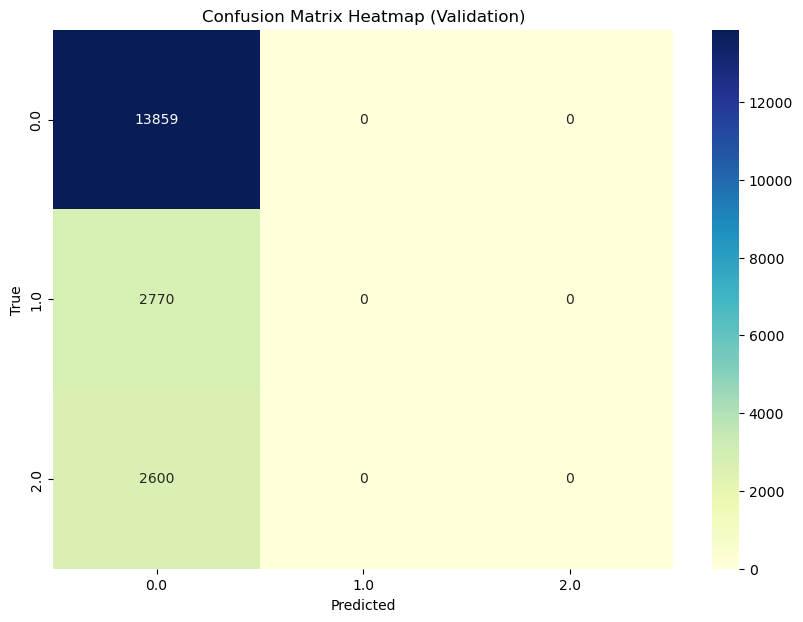

/opt/miniconda3/envs/condaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/condaenv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SGDClassifier was fitted without feature names
  warnings.warn(



Test Set Performance:
Confusion Matrix (Test):
[[6328    0    0]
 [1494    0    0]
 [1793    0    0]]
Accuracy: 0.6581383255330213
Precision: 0.43314605553540914
Recall: 0.6581383255330213
F1 Score: 0.5224486387722459
AUC Score (Test): Not applicable for multi-class with current configuration


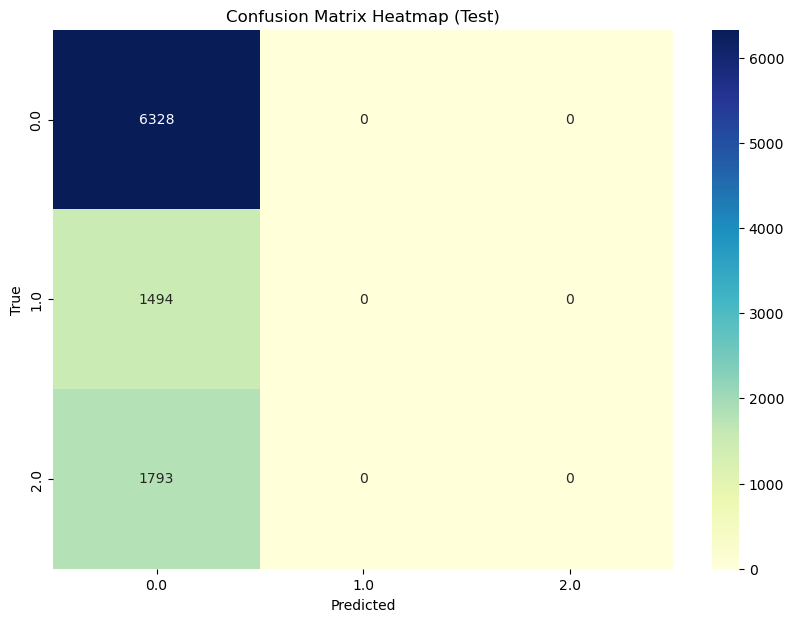

In [11]:
def train_validate_and_evaluate_model_sgd(train_df, validation_df, test_df, lookback_period, target_column='Direction'):
    y_true_val = []
    y_pred_val = []
    y_true_test = []
    y_pred_test = []

    # Remove constant features from the entire dataset initially
    train_df = remove_constant_features(train_df)
    validation_df = validation_df[train_df.columns]  # Ensure validation set has the same columns
    test_df = test_df[train_df.columns]  # Ensure test set has the same columns

    # Initialize SGDClassifier
    model = SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3, class_weight=class_weights_dict)
    
    unique_classes = train_df[target_column].unique()

    feature_selector = None

    total_windows = len(train_df) - lookback_period

    for end in range(lookback_period, len(train_df)):
        start = end - lookback_period
        train_subset = train_df.iloc[start:end]
        
        X_train = train_subset.drop(columns=[target_column])
        y_train = train_subset[target_column]

        X_train = X_train.fillna(X_train.mean())
        X_train = remove_constant_features(X_train)

        if X_train.shape[0] == 0:
            print(f"Skipping window from {start} to {end}: Training data is empty.")
            continue

        if X_train.var().sum() == 0:
            print(f"Skipping window from {start} to {end}: Insufficient variance in features.")
            continue

        k_features = min(10, X_train.shape[1])
        if feature_selector is None:
            feature_selector = SelectKBest(f_classif, k=k_features)

        try:
            X_train = feature_selector.fit_transform(X_train, y_train)
        except ValueError as e:
            print(f"Error during feature selection in window {start} to {end}: {e}")
            continue

        try:
            model.partial_fit(X_train, y_train, classes=unique_classes)
        except ValueError as e:
            print(f"Error during partial_fit in window {start} to {end}: {e}")
            continue

        if (end - lookback_period) % (total_windows // 10) == 0:  # Update every 10%
            progress = (end - lookback_period) / total_windows * 100
            print(f"Training progress: {progress:.2f}%")

    # Validation Data
    X_val = validation_df.drop(columns=[target_column])
    y_val = validation_df[target_column]

    X_val = X_val.fillna(X_val.mean())
    X_val = remove_constant_features(X_val)

    if X_val.shape[0] == 0:
        print("Validation failed due to no non-constant features in validation set")
        return model, feature_selector, y_val.tolist(), [], [], []

    if feature_selector:
        X_val = feature_selector.transform(X_val)
    else:
        print("No valid feature selector was trained")
        return model, feature_selector, y_val.tolist(), [], [], []

    try:
        y_pred_val = model.predict(X_val)
    except NotFittedError as e:
        print(f"Error during prediction: {e}")
        return model, feature_selector, y_val.tolist(), [], [], []

    y_true_val = y_val.tolist()

    # Test Data
    X_test = test_df.drop(columns=[target_column])
    y_test = test_df[target_column]

    X_test = X_test.fillna(X_test.mean())
    X_test = remove_constant_features(X_test)

    if feature_selector:
        X_test = feature_selector.transform(X_test)

    y_pred_test = model.predict(X_test)
    y_true_test = y_test.tolist()

    print(f"Lookback period: {lookback_period}")
    print("Model training, validation, and testing complete.")

    return model, feature_selector, y_true_val, y_pred_val, y_true_test, y_pred_test

# Define your splits
validation_start = int(len(filtered_df) * 0.7)  # 70% training data
test_start = int(len(filtered_df) * 0.9)        # 20% validation data

# Split the data
train_df, validation_df, test_df = split_data(filtered_df, validation_start, test_start)

# Train, validate, and evaluate models
model, feature_selector, y_true_val, y_pred_val, y_true_test, y_pred_test = train_validate_and_evaluate_model_sgd(
    train_df, validation_df, test_df, lookback_period=4320, target_column='Direction'
)

# Evaluate the model on both validation and test sets
evaluate_model(y_true_val, y_pred_val, y_true_test=y_true_test, y_pred_test=y_pred_test, model=model, X_val=validation_df.drop(columns=['Direction']), X_test=test_df.drop(columns=['Direction']))


---------------------------------

### Second Training Attempt (Lookback: 11700 Minutes, ~ 30 Trading Days)
- **Class Weights:** 0: 0.46, 1 & 2: 10.0.

Training progress: 0.00%
Training progress: 10.00%
Training progress: 20.00%
Training progress: 30.00%
Training progress: 40.00%
Training progress: 50.00%
Training progress: 60.00%
Training progress: 70.00%
Training progress: 80.00%
Training progress: 90.00%
Training progress: 100.00%
Lookback period: 11700
Model training, validation, and testing complete.
Validation Set Performance:
Confusion Matrix (Validation):
[[9034 4786   39]
 [1674 1083   13]
 [1515 1070   15]]
Accuracy: 0.5269124759477872
Precision: 0.5854480499548382
Recall: 0.5269124759477872
F1 Score: 0.5329383242953841
AUC Score (Validation): Not applicable for multi-class with current configuration


/opt/miniconda3/envs/condaenv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SGDClassifier was fitted without feature names
  warnings.warn(


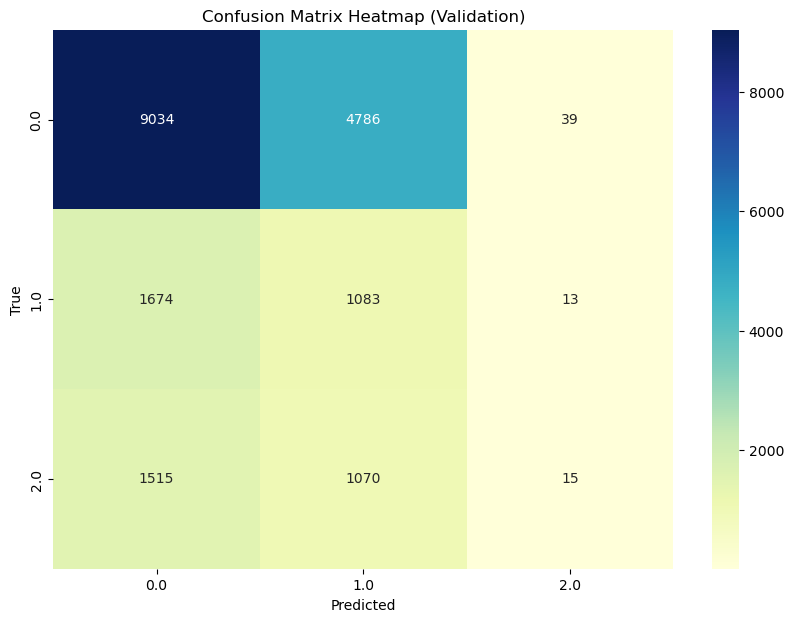

/opt/miniconda3/envs/condaenv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SGDClassifier was fitted without feature names
  warnings.warn(



Test Set Performance:
Confusion Matrix (Test):
[[4723 1597    8]
 [1055  424   15]
 [1375  398   20]]
Accuracy: 0.5373894955798232
Precision: 0.5485270303011921
Recall: 0.5373894955798232
F1 Score: 0.4988870110352257
AUC Score (Test): Not applicable for multi-class with current configuration


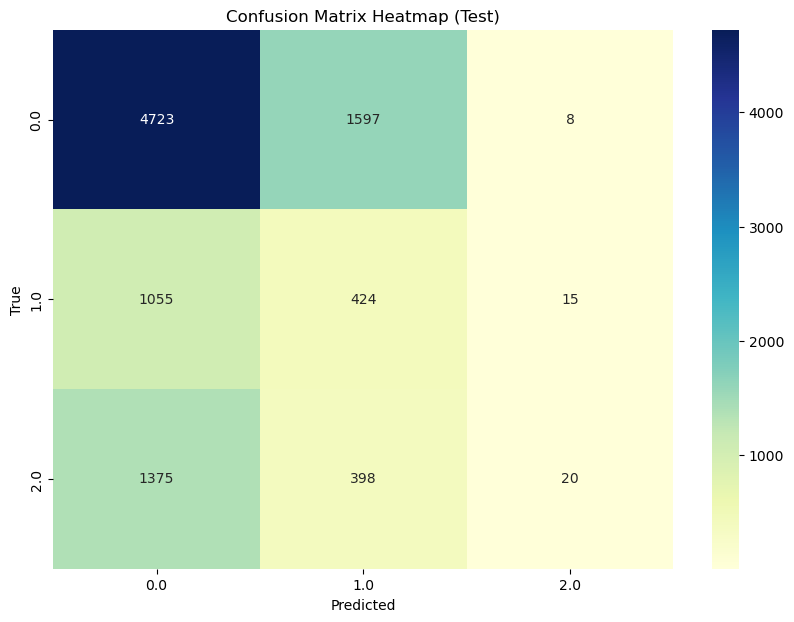

In [7]:
def train_validate_and_evaluate_model_sgd(train_df, validation_df, test_df, lookback_period, target_column='Direction'):
    y_true_val = []
    y_pred_val = []
    y_true_test = []
    y_pred_test = []

    # Remove constant features from the entire dataset initially
    train_df = remove_constant_features(train_df)
    validation_df = validation_df[train_df.columns]  # Ensure validation set has the same columns
    test_df = test_df[train_df.columns]  # Ensure test set has the same columns

    # Define steeper class weights
    class_weights_dict = {0.0: 0.45996920164446264, 1.0: 10, 2.0: 10}

    # Initialize SGDClassifier with steeper class weights
    model = SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3, class_weight=class_weights_dict)
    
    unique_classes = train_df[target_column].unique()

    feature_selector = None

    total_windows = len(train_df) - lookback_period

    for end in range(lookback_period, len(train_df)):
        start = end - lookback_period
        train_subset = train_df.iloc[start:end]
        
        X_train = train_subset.drop(columns=[target_column])
        y_train = train_subset[target_column]

        X_train = X_train.fillna(X_train.mean())
        X_train = remove_constant_features(X_train)

        if X_train.shape[0] == 0:
            print(f"Skipping window from {start} to {end}: Training data is empty.")
            continue

        if X_train.var().sum() == 0:
            print(f"Skipping window from {start} to {end}: Insufficient variance in features.")
            continue

        k_features = min(10, X_train.shape[1])
        if feature_selector is None:
            feature_selector = SelectKBest(f_classif, k=k_features)

        try:
            X_train = feature_selector.fit_transform(X_train, y_train)
        except ValueError as e:
            print(f"Error during feature selection in window {start} to {end}: {e}")
            continue

        try:
            model.partial_fit(X_train, y_train, classes=unique_classes)
        except ValueError as e:
            print(f"Error during partial_fit in window {start} to {end}: {e}")
            continue

        if (end - lookback_period) % (total_windows // 10) == 0:  # Update every 10%
            progress = (end - lookback_period) / total_windows * 100
            print(f"Training progress: {progress:.2f}%")

    # Validation Data
    X_val = validation_df.drop(columns=[target_column])
    y_val = validation_df[target_column]

    X_val = X_val.fillna(X_val.mean())
    X_val = remove_constant_features(X_val)

    if X_val.shape[0] == 0:
        print("Validation failed due to no non-constant features in validation set")
        return model, feature_selector, y_val.tolist(), [], [], []

    if feature_selector:
        X_val = feature_selector.transform(X_val)
    else:
        print("No valid feature selector was trained")
        return model, feature_selector, y_val.tolist(), [], [], []

    try:
        y_pred_val = model.predict(X_val)
    except NotFittedError as e:
        print(f"Error during prediction: {e}")
        return model, feature_selector, y_val.tolist(), [], [], []

    y_true_val = y_val.tolist()

    # Test Data
    X_test = test_df.drop(columns=[target_column])
    y_test = test_df[target_column]

    X_test = X_test.fillna(X_test.mean())
    X_test = remove_constant_features(X_test)

    if feature_selector:
        X_test = feature_selector.transform(X_test)

    y_pred_test = model.predict(X_test)
    y_true_test = y_test.tolist()

    print(f"Lookback period: {lookback_period}")
    print("Model training, validation, and testing complete.")

    return model, feature_selector, y_true_val, y_pred_val, y_true_test, y_pred_test

# Define your splits
validation_start = int(len(filtered_df) * 0.7)  # 70% training data
test_start = int(len(filtered_df) * 0.9)        # 20% validation data

# Split the data
train_df, validation_df, test_df = split_data(filtered_df, validation_start, test_start)

# Train, validate, and evaluate models
model, feature_selector, y_true_val, y_pred_val, y_true_test, y_pred_test = train_validate_and_evaluate_model_sgd(
    train_df, validation_df, test_df, lookback_period=11700, target_column='Direction'
)

# Evaluate the model on both validation and test sets
evaluate_model(y_true_val, y_pred_val, y_true_test=y_true_test, y_pred_test=y_pred_test, model=model, X_val=validation_df.drop(columns=['Direction']), X_test=test_df.drop(columns=['Direction']))


## Decision Tree Classifier Results (Lookback: 7800 Minutes ~ 20 Trading Days)

- **Class Weights:** 0: 0.46, 1: 2.35, 2: 2.49.

Training progress: 0.00%
Training progress: 10.00%
Training progress: 20.00%
Training progress: 30.00%
Training progress: 40.00%
Training progress: 50.00%
Training progress: 60.00%
Training progress: 70.00%
Training progress: 80.00%
Training progress: 90.00%
Training progress: 100.00%
Lookback period: 7800
Model training, validation, and testing complete.
Validation Set Performance:
Confusion Matrix (Validation):
[[6744 1270 5845]
 [1500  290  980]
 [1350  185 1065]]
Accuracy: 0.42118674918092464
Precision: 0.5488236872720459
Recall: 0.42118674918092464
F1 Score: 0.46045995915460025
AUC Score (Validation): Not applicable for multi-class with current configuration


/opt/miniconda3/envs/condaenv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


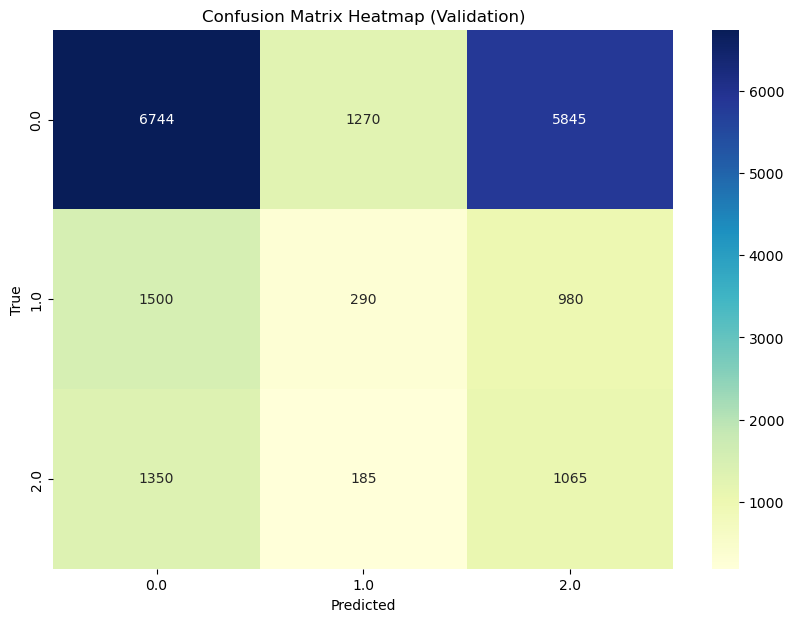

/opt/miniconda3/envs/condaenv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(



Test Set Performance:
Confusion Matrix (Test):
[[3876   20 2432]
 [ 939   88  467]
 [1057   28  708]]
Accuracy: 0.4859074362974519
Precision: 0.5715696479503636
Recall: 0.4859074362974519
F1 Score: 0.48386408991063007
AUC Score (Test): Not applicable for multi-class with current configuration


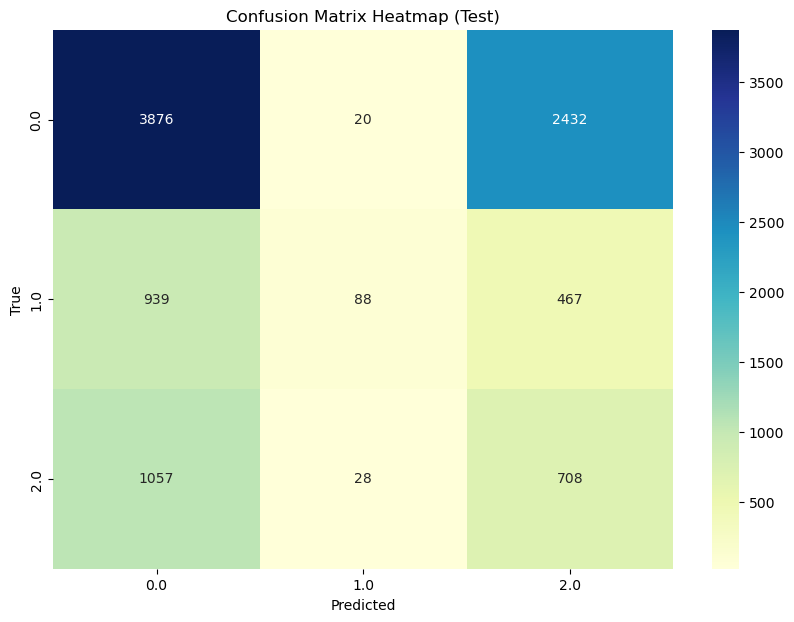

In [10]:
def train_validate_and_evaluate_model_dt(train_df, validation_df, test_df, lookback_period, target_column='Direction'):
    y_true_val = []
    y_pred_val = []
    y_true_test = []
    y_pred_test = []

    # Remove constant features from the entire dataset initially
    train_df = remove_constant_features(train_df)
    validation_df = validation_df[train_df.columns]  # Ensure validation set has the same columns
    test_df = test_df[train_df.columns]  # Ensure test set has the same columns

    # Initialize DecisionTreeClassifier
    model = DecisionTreeClassifier(class_weight=class_weights_dict)

    unique_classes = train_df[target_column].unique()

    feature_selector = None

    total_windows = len(train_df) - lookback_period

    for end in range(lookback_period, len(train_df)):
        start = end - lookback_period
        train_subset = train_df.iloc[start:end]
        
        X_train = train_subset.drop(columns=[target_column])
        y_train = train_subset[target_column]

        X_train = X_train.fillna(X_train.mean())
        X_train = remove_constant_features(X_train)

        if X_train.shape[0] == 0:
            print(f"Skipping window from {start} to {end}: Training data is empty.")
            continue

        if X_train.var().sum() == 0:
            print(f"Skipping window from {start} to {end}: Insufficient variance in features.")
            continue

        k_features = min(10, X_train.shape[1])
        if feature_selector is None:
            feature_selector = SelectKBest(f_classif, k=k_features)

        try:
            X_train = feature_selector.fit_transform(X_train, y_train)
        except ValueError as e:
            print(f"Error during feature selection in window {start} to {end}: {e}")
            continue

        try:
            model.fit(X_train, y_train)
        except ValueError as e:
            print(f"Error during fitting in window {start} to {end}: {e}")
            continue

        if (end - lookback_period) % (total_windows // 10) == 0:  # Update every 10%
            progress = (end - lookback_period) / total_windows * 100
            print(f"Training progress: {progress:.2f}%")

    # Validation Data
    X_val = validation_df.drop(columns=[target_column])
    y_val = validation_df[target_column]

    X_val = X_val.fillna(X_val.mean())
    X_val = remove_constant_features(X_val)

    if X_val.shape[0] == 0:
        print("Validation failed due to no non-constant features in validation set")
        return y_val.tolist(), []

    if feature_selector:
        X_val = feature_selector.transform(X_val)
    else:
        print("No valid feature selector was trained")
        return y_val.tolist(), []

    try:
        y_pred_val = model.predict(X_val)
    except NotFittedError as e:
        print(f"Error during prediction: {e}")
        return y_val.tolist(), []

    y_true_val = y_val.tolist()

    # Test Data
    X_test = test_df.drop(columns=[target_column])
    y_test = test_df[target_column]

    X_test = X_test.fillna(X_test.mean())
    X_test = remove_constant_features(X_test)

    if feature_selector:
        X_test = feature_selector.transform(X_test)

    y_pred_test = model.predict(X_test)
    y_true_test = y_test.tolist()

    print(f"Lookback period: {lookback_period}")
    print("Model training, validation, and testing complete.")

    return model, feature_selector, y_true_val, y_pred_val, y_true_test, y_pred_test

# Define your splits
validation_start = int(len(filtered_df) * 0.7)  # 70% training data
test_start = int(len(filtered_df) * 0.9)        # 20% validation data

# Split the data
train_df, validation_df, test_df = split_data(filtered_df, validation_start, test_start)

# Train, validate, and evaluate models
model, feature_selector, y_true_val, y_pred_val, y_true_test, y_pred_test = train_validate_and_evaluate_model_dt(
    train_df, validation_df, test_df, lookback_period=7800, target_column='Direction'
)

# Evaluate the model on both validation and test sets
evaluate_model(y_true_val, y_pred_val, y_true_test=y_true_test, y_pred_test=y_pred_test, model=model, X_val=validation_df.drop(columns=['Direction']), X_test=test_df.drop(columns=['Direction']))


## Minibatch K-means Classifier

Training progress: 0.00%
Training progress: 10.00%
Training progress: 20.00%
Training progress: 30.00%
Training progress: 40.00%
Training progress: 50.00%
Training progress: 60.00%
Training progress: 70.00%
Training progress: 80.00%
Training progress: 90.00%
Training progress: 100.00%
Lookback period: 11700
Model training, validation, and testing complete.
Validation Set Performance:
Confusion Matrix (Validation):
[[13859     0     0]
 [ 2770     0     0]
 [ 2600     0     0]]
Accuracy: 0.7207343075562952
Precision: 0.5194579420886524
Recall: 0.7207343075562952
F1 Score: 0.6037631025400566
AUC Score (Validation): Model does not support probability prediction


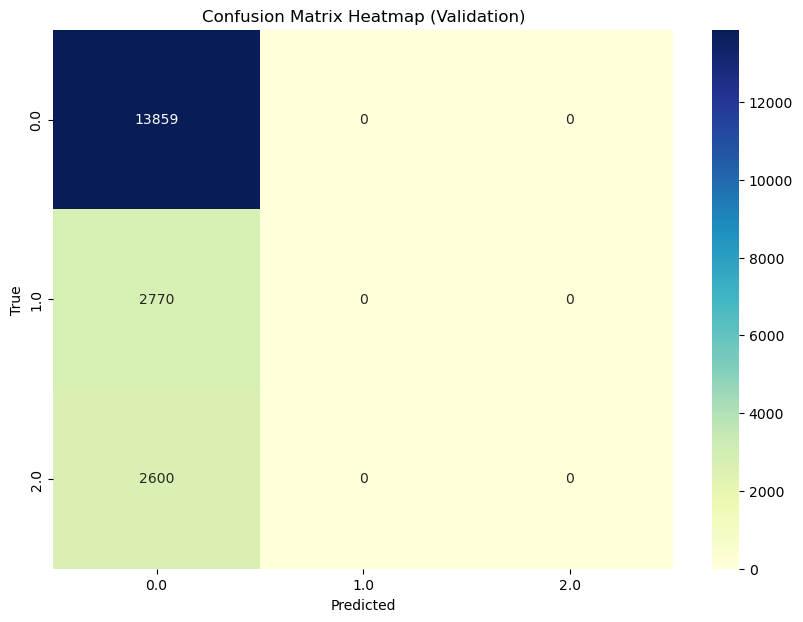


Test Set Performance:
Confusion Matrix (Test):
[[6328    0    0]
 [1494    0    0]
 [1793    0    0]]
Accuracy: 0.6581383255330213
Precision: 0.43314605553540914
Recall: 0.6581383255330213
F1 Score: 0.5224486387722459
AUC Score (Test): Model does not support probability prediction


/opt/miniconda3/envs/condaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


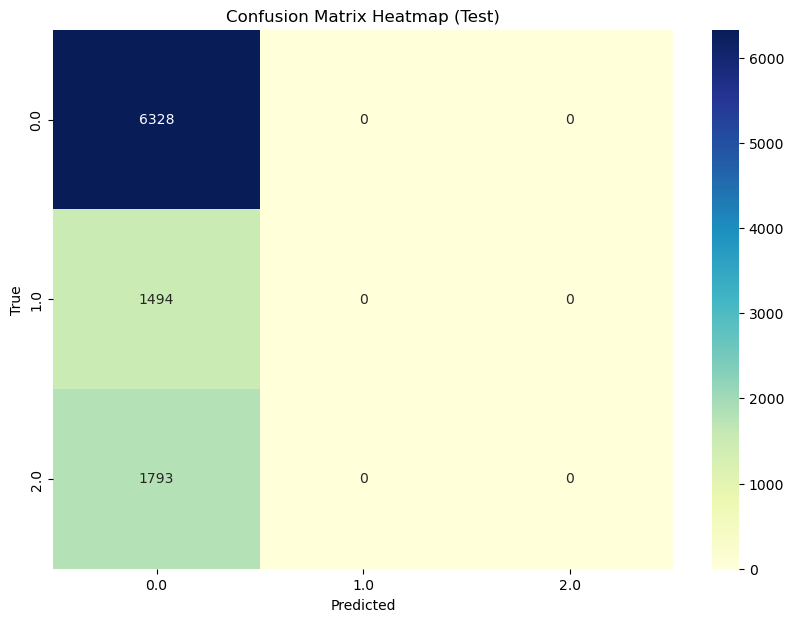

In [20]:
def train_validate_and_evaluate_model_kmeans(train_df, validation_df, test_df, lookback_period, target_column='Direction', class_weights=None):
    y_true_val = []
    y_pred_val = []
    y_true_test = []
    y_pred_test = []

    # Remove constant features from the entire dataset initially
    train_df = remove_constant_features(train_df)
    validation_df = validation_df[train_df.columns]  # Ensure validation set has the same columns
    test_df = test_df[train_df.columns]  # Ensure test set has the same columns

    # Determine the number of unique classes in the target
    unique_classes = train_df[target_column].unique()
    n_clusters = len(unique_classes)

    # Initialize MiniBatchKMeans with the number of clusters equal to the number of unique classes
    model = MiniBatchKMeans(n_clusters=n_clusters, random_state=42)

    feature_selector = None

    total_windows = len(train_df) - lookback_period

    for end in range(lookback_period, len(train_df)):
        start = end - lookback_period
        train_subset = train_df.iloc[start:end]
        
        X_train = train_subset.drop(columns=[target_column])
        y_train = train_subset[target_column]  # This won't be used for fitting, only for comparison

        X_train = X_train.fillna(X_train.mean())
        X_train = remove_constant_features(X_train)

        if X_train.shape[0] == 0:
            print(f"Skipping window from {start} to {end}: Training data is empty.")
            continue

        if X_train.var().sum() == 0:
            print(f"Skipping window from {start} to {end}: Insufficient variance in features.")
            continue

        k_features = min(10, X_train.shape[1])
        if feature_selector is None:
            feature_selector = SelectKBest(f_classif, k=k_features)

        try:
            X_train = feature_selector.fit_transform(X_train, y_train)
        except ValueError as e:
            print(f"Error during feature selection in window {start} to {end}: {e}")
            continue

        # Apply class weights by duplicating samples based on the weight
        if class_weights:
            weighted_indices = np.hstack([
                np.repeat(np.where(y_train == cls)[0], int(class_weights.get(cls, 1.0)))
                for cls in unique_classes
            ])
            X_train_weighted = X_train[weighted_indices]
            y_train_weighted = y_train.iloc[weighted_indices]
        else:
            X_train_weighted = X_train
            y_train_weighted = y_train

        try:
            model.partial_fit(X_train_weighted)
        except ValueError as e:
            print(f"Error during fitting in window {start} to {end}: {e}")
            continue

        if (end - lookback_period) % (total_windows // 10) == 0:  # Update every 10%
            progress = (end - lookback_period) / total_windows * 100
            print(f"Training progress: {progress:.2f}%")

    # Validation Data
    X_val = validation_df.drop(columns=[target_column])
    y_val = validation_df[target_column]

    X_val = X_val.fillna(X_val.mean())
    X_val = remove_constant_features(X_val)

    if X_val.shape[0] == 0:
        print("Validation failed due to no non-constant features in validation set")
        return model, feature_selector, y_val.tolist(), [], [], []

    if feature_selector:
        X_val = feature_selector.transform(X_val)
    else:
        print("No valid feature selector was trained")
        return model, feature_selector, y_val.tolist(), [], [], []

    try:
        y_pred_val = model.predict(X_val)
    except Exception as e:
        print(f"Error during prediction: {e}")
        return model, feature_selector, y_val.tolist(), [], [], []

    # Map clusters to the most frequent true label
    labels_map = {}
    for cluster in range(n_clusters):
        mask = (y_pred_val == cluster)
        if np.sum(mask) > 0:
            most_common_label = mode(y_val[mask]).mode
            if isinstance(most_common_label, np.ndarray):
                most_common_label = most_common_label[0]
            labels_map[cluster] = most_common_label

    y_pred_val = np.array([labels_map.get(label, -1) for label in y_pred_val])
    y_true_val = y_val.tolist()

    # Test Data
    X_test = test_df.drop(columns=[target_column])
    y_test = test_df[target_column]

    X_test = X_test.fillna(X_test.mean())
    X_test = remove_constant_features(X_test)

    if feature_selector:
        X_test = feature_selector.transform(X_test)

    y_pred_test = model.predict(X_test)

    # Map clusters to the most frequent true label in the test set
    y_pred_test = np.array([labels_map.get(label, -1) for label in y_pred_test])
    y_true_test = y_test.tolist()

    print(f"Lookback period: {lookback_period}")
    print("Model training, validation, and testing complete.")

    return model, feature_selector, y_true_val, y_pred_val, y_true_test, y_pred_test

# Define your splits
validation_start = int(len(filtered_df) * 0.7)  # 70% training data
test_start = int(len(filtered_df) * 0.9)        # 20% validation data

# Split the data
train_df, validation_df, test_df = split_data(filtered_df, validation_start, test_start)

# Define custom class weights
class_weights = {
    0.0: 0.45996920164446264,  # Weight for class 0 (no significant change)
    1.0: 10,    # Weight for class 1 (stock goes up)
    2.0: 10    # Weight for class 2 (stock goes down)
}

# Train, validate, and evaluate the model with custom weights
model, feature_selector, y_true_val, y_pred_val, y_true_test, y_pred_test = train_validate_and_evaluate_model_kmeans(
    train_df, 
    validation_df, 
    test_df, 
    lookback_period=11700, 
    target_column='Direction', 
    class_weights=class_weights  # Pass the custom class weights here
)

# Evaluate the model on both validation and test sets
evaluate_model(
    y_true_val, 
    y_pred_val, 
    y_true_test=y_true_test, 
    y_pred_test=y_pred_test, 
    model=model, 
    X_val=validation_df.drop(columns=['Direction']), 
    X_test=test_df.drop(columns=['Direction'])
)